Welcome to the **Monitoring with Prometheus** lab. 

In this lab, 
* You will become familiar with using **Prometheus** to monitor sample servers simulated with **node_exporter**.
* You will use **Prometheus** to monitor the target **node_exporter** application that is configured by **scraping metrics** endpoints of the **node_exporter**.
* You will finish the lab by learning how to instrument a Python Flask application to emit metrics and deploy that application so that **Prometheus** can monitor it.

# Learning Objectives

After completing this exercise, you should be able to:
* Configure the targets for **Prometheus** to monitor
* Create queries to get the metrics about the target
* Determine the status of the targets
* Identify information about the targets and visualize it with graphs
* Instrument a Python Flask application to be monitored by **Prometheus**

# Prerequisites

* This lab uses **Docker** to run both **Prometheus**, and special **Node Exporters**, which will behave like servers that you can monitor. 
* As a prerequisite, you will pull down the **`bitnami/prometheus:latest`** image and the **`bitnami/node-exporter`** image from Docker Hub. 
* You will use these images to run **Prometheus** and create three instances of node exporters to be monitored.

## Your Task

1. To start this lab, you will need a terminal. If a terminal is not already open, you can open one from the top menu. Go to **Terminal** and choose **New Terminal** to open a new terminal window.

2. Next, use the following **`docker pull`** command to pull down the **`bitnami/node-exporter`** image from Docker Hub that you will use to simulate three servers being monitored.

```
docker pull bitnami/node-exporter:latest
```

Your output should look similar to this:

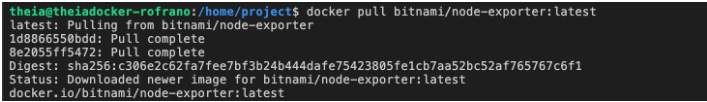

Then, pull the Prometheus docker image into your lab environment, by running the following **`docker pull`** command in the terminal.

```
docker pull bitnami/prometheus:latest
```

Your output should look similar to this:

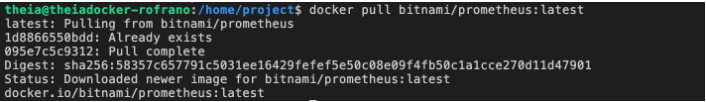

You are now ready to start the lab.

# Step 1: Start the first node exporter

The first thing you will need is some server nodes to monitor.
* You will start up three node exporters listening on port `9100` and forwarding to ports `9101`, `9102`, and `9103`, respectively.
* Each node will need to be started up individually.

In this step, you will create a **Docker network** for all of the **node exporters** and **Prometheus** to communicate on, and start just the first node, `9101`, and ensure it is working correctly.


## Your Task

1. Start by running the following **`docker network`** command to create a network called **`monitor`** within which we will run all of the docker containers.
```
docker network create monitor
```
    
2. Next, run the following **`docker run`** command to start a node exporter instance on the **`monitor`** network, listening at port `9101` externally and forwarding to port `9100` internally.
```
docker run -d --name node-exporter1 -p 9101:9100 --network monitor bitnami/node-exporter:latest
```
    
> * This will start an instance named node_exporter1 of node-exporter.
> * The output should look something like this (***note: the container id will be different each time***):

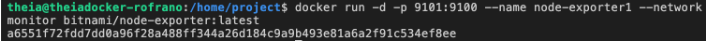

3. Next, check if the instance is running by pressing the **`[Launch Application]`** button, which will launch the application on port `9101`:



4. You should see the Node Exporter page open up with a hyperlink to **Metrics**. These are the metrics the Prometheus instance is going to monitor.

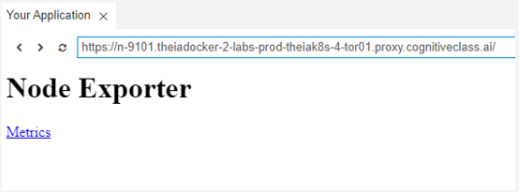

5. Finally, click the **Metrics** link to see the metrics.

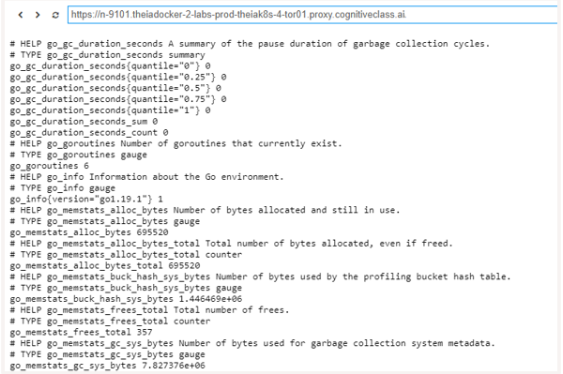

# Step 2: Start two more node exporters

* Now that you have one **node exporter** working, you can start two more so that **Prometheus** has three nodes to monitor in total. 
* You will do this the same way as you did the first node exporter, except that you will change the external port numbers to `9102` and `9103`, respectively.

# Your Task

1. In the terminal, run the following commands to start two more instances of node exporter.

```
docker run -d --name node-exporter2 -p 9102:9100 --network monitor bitnami/node-exporter:latest
docker run -d --name node-exporter3 -p 9103:9100 --network monitor bitnami/node-exporter:latest
```

2. Now, check if all the instances of node exporter are running by using the **`docker ps`** command and pipe it through the **`grep`** command to search for **`node-exporter`**.

```
docker ps | grep node-exporter
```

## Results

If everything started correctly, you should see output similar to the following coming back from the **`docker ps`** command:

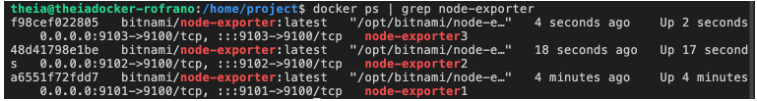

You are now ready to configure and run Prometheus.

# Step 3: Configure and run Prometheus

Before you can start Prometheus, you need to create a configuration file called **`prometheus.yml`** to instruct Prometheus on which nodes to monitor.

In this step, you will create a custom configuration file to monitor the three node exporters running internally on the **`monitor`** network at **`node-exporter1:9100`**, **`node-exporter2:9100`**, and **`node-exporter3:9100`**, respectively. Then you will start Prometheus by passing it the configuration file to use.

## Your Task

1. First, use the `touch` command to create a file named **prometheus.yml** in the current directory. This is the file where you will configure the Prometheus to monitor the node exporter instances.

```
touch /home/project/prometheus.yml
```

2. Next, from **Explorer**, navigate to **Project**, and then select **`prometheus.yml`** to edit the file.

3. Then, copy and paste the following configuration contents into the yaml file and save it:

```
# my global config
global:
  scrape_interval: 15s # Set the scrape interval to every 15 seconds. The default is every 1 minute.

scrape_configs:
  - job_name: 'node'
    static_configs:
      - targets: ['node-exporter1:9100']
        labels:
          group: 'monitoring_node_ex1'
      - targets: ['node-exporter2:9100']
        labels:
          group: 'monitoring_node_ex2'
      - targets: ['node-exporter3:9100']
        labels:
          group: 'monitoring_node_ex3'
```

> Notice that while you access the node exporters externally on ports **`9101`**, **`9102`**, and **`9103`**, they are internally all listening on port **`9100`**, which is how **Prometheus** will communicate them on the **`monitor`** network.

Take a look at what this file is doing:
* Globally, you set the **`scrape_interval`** to **`15`** seconds instead of the default of **`1`** minute. This is so that we can see results quicker during the lab, but the 1 minute interval is better for production use.
* The **`scrape_config`** section contains all the jobs that **Prometheus** is going to monitor. These job names have to be unique. You currently have one job called **`node`**. Later we will add another to monitor a Python application.
* Within each job, there is a **`static_configs`** section where you define the targets and define labels for easy identification and analysis. These will show up in the Prometheus UI under the **Targets** tab.
* The targets you enter here point to the base URL of the service running on each of the nodes. Prometheus will add the suffix **`/metrics`** and call that endpoint to collect the data to monitor from. (For example, **`node-exporter1:9100/metrics`**)

You will have an opportunity to create your own Prometheus file to monitor your Python application in the practice exercise.

4. Finally, you can launch the Prometheus monitor in the terminal by executing the following **`docker run`** command passing the yaml configuration file as a volume mount with the **`-v`** parameter.

```
docker run -d --name prometheus -p 9090:9090 --network monitor \
-v $(pwd)/prometheus.yml:/opt/bitnami/prometheus/conf/prometheus.yml \
bitnami/prometheus:latest
```

> **Note**: This Dockerized distribution of Prometheus from Bitnami expects its configuration file to be in the **`/opt/bitnami/prometheus/conf/prometheus.yml`** file, which is why you are mapping your **`prometheus.yml`** file to this location. Other distributions may look in other locations. Always check the documentation to be sure of where to mount the configuration file.


## Results

You should see just the Prometheus container id returned, indicating that Docker has started Prometheus in the background.

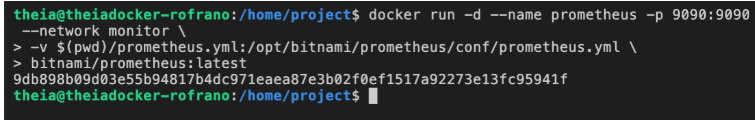

You are now ready to do some monitoring.

# Step 4: Open the Prometheus UI

In this step, you will launch the **Prometheus web UI** in an external browser window and navigate to the page where you start executing queries.

1. Open the Prometheus web UI by clicking **Skills Network Toolbox**. Under **Other**, select **Launch Application**, in **Application Port** enter the port number `9090`, and then click the launch URL button.

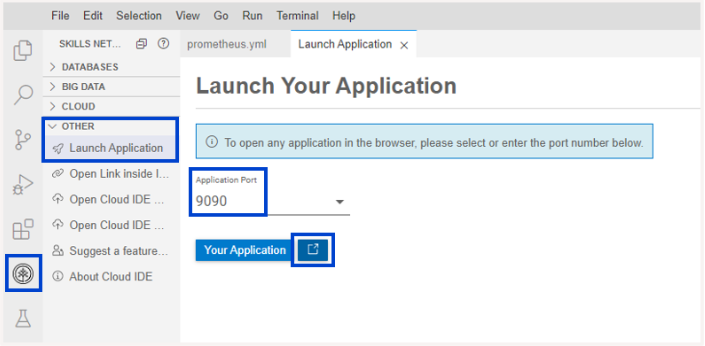

Or click the **Launch Prometheus** button below to launch in an external browser.



2. The Prometheus application UI opens up.

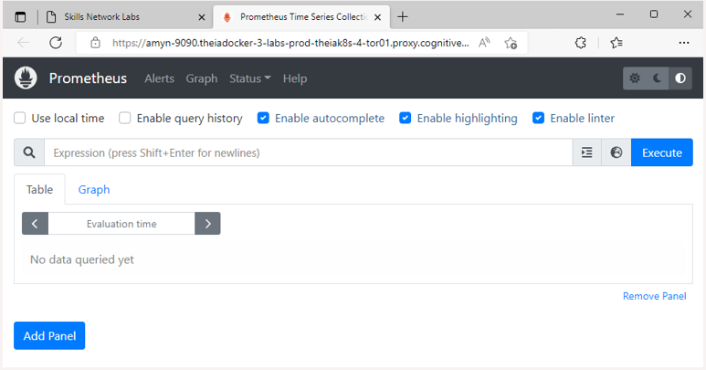

3. Next, in the Prometheus application, click **Status** on the menu and choose **Targets** to see which targets are being monitored.

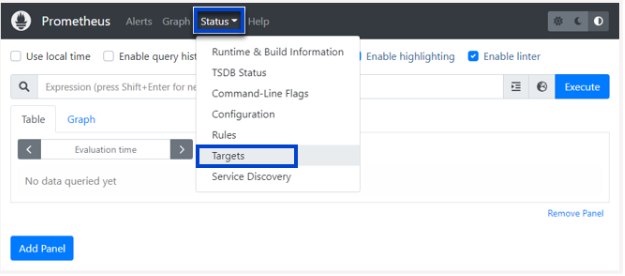

4. View the status of all three node exporters.

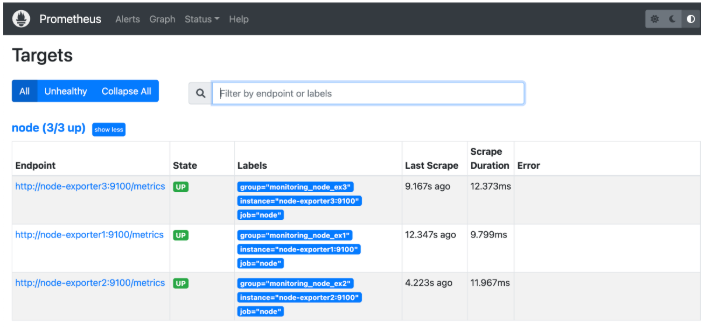

5. Click **Graph** to return to the home page.

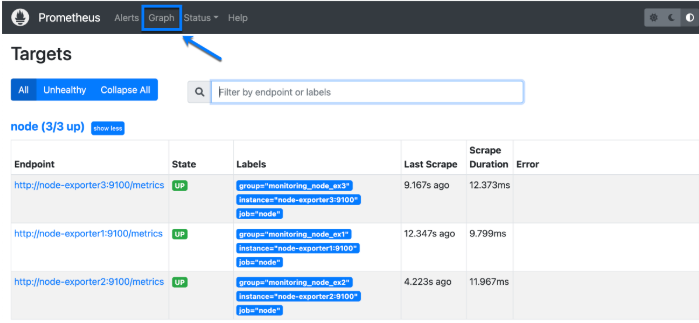

You are now ready to execute queries.

# Step 5: Execute your first query

* You are now ready to execute your first query. 
* The first query you run will query the nodes for the total CPU seconds. 
* It will show the graph as given in the image. 
* You can observe the details for each instance by hovering the mouse over that instance.

## Your Task

1. Ensure you are on the **Graph** tab, and then copy and paste the following query and press the blue **Execute** button on the right, or press **`return`** on your keyboard to run it. It will show the graph as given in the image. You can observe the details for each instance by hovering the mouse over that instance.

```
node_cpu_seconds_total
```

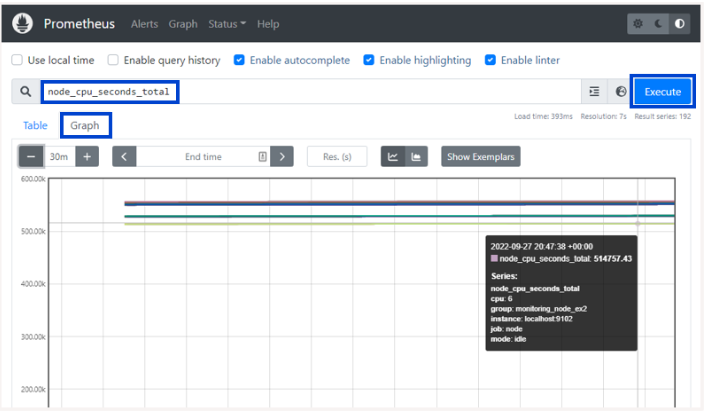

2. Next, click **Table** to see the CPU seconds for all the targets in tabular format.

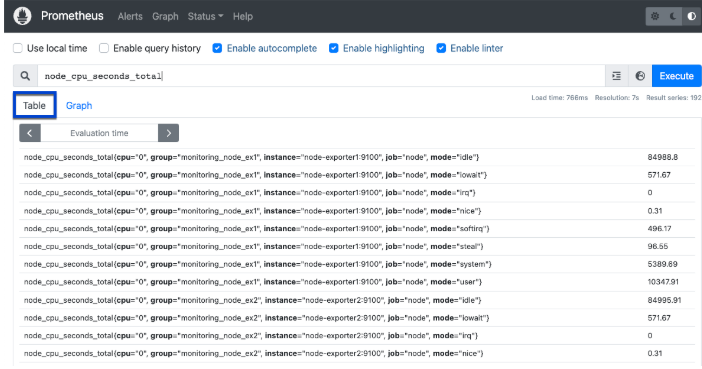

3. Now, filter the query to get the details for only one instance **`node-exporter2`** using the following query.

```
node_cpu_seconds_total{instance="node-exporter2:9100"}
```

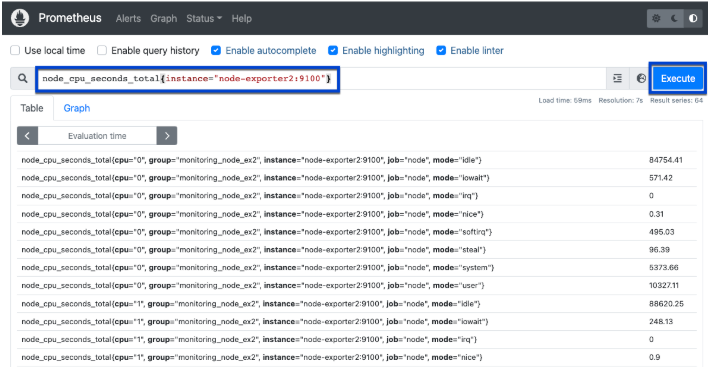

4. Finally, query for the connections each node has using this query.

```
node_ipvs_connections_total
```

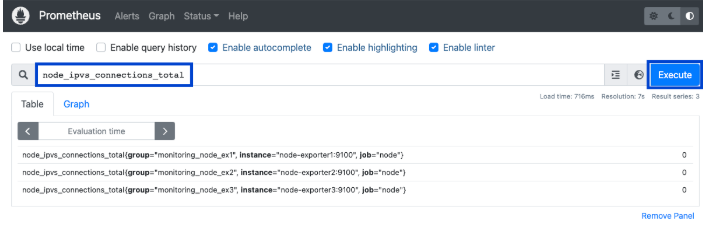

# Step 6: Stop and observe

In this step, we will stop one of the node exporter instances and see how that is reflected in the Prometheus console.

## Your Task

1. Stop the node-exporter1 instance by running the following **`docker stop`** command and then switch back to the old terminal in which Prometheus is running.

```
docker stop node-exporter1
```
    
2. Now go back to the Prometheus UI on your browser and check the targets by selecting the menu item **Status -> Targets**.



## Results

You should now see that one of the node exporters that are being monitored is down. The nodes might not be displayed in the same order, but the node which is should be **`node-exporter1`**, is the node that you stopped.

> **Note**: You configured Prometheus to **scrape every 15 seconds**, so you may have to wait that long and press refresh on your browser to see the status change.

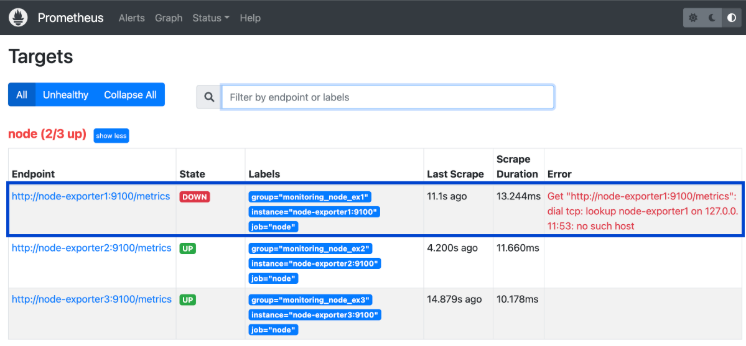

# Step 7: Enable your application

Monitoring node exporters is fine for a demonstration, but you are a software engineer. You need to know how to enable your applications to be monitored by Prometheus. There is no magic here. Metrics do not simply appear out of nowhere. You must instrument your application to emit metrics on an endpoint called **`/metrics`** in order for Prometheus to be able to monitor your application.

Luckily there is a Python package called **Prometheus Flask exporter** for Prometheus that will do this for you. In this step, you will create a simple Python Flask application and enable a metrics endpoint so that you can monitor it.

## Your Task

Below is a code for a Python Flask server with three endpoints, **`/`**, **`/home`**, and **`/contact`**. The code uses the package **`prometheus_flask_exporter`** for generating metrics for Prometheus to monitor.

1. First, create a file named **`pythonserver.py`** in the **`/home/project`** folder. Press the button below and answer **Create the file** when prompted.

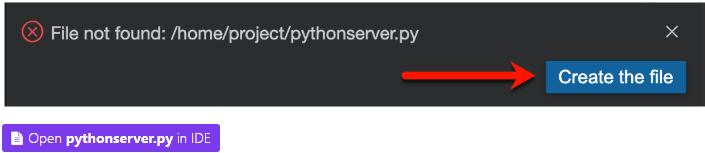

2. Then, paste the following code content into it:

```
from prometheus_flask_exporter import PrometheusMetrics
from flask import Flask

app = Flask(__name__)
metrics = PrometheusMetrics.for_app_factory()
metrics.init_app(app)

@app.route('/')
def root():
    return 'Hello from root!'

@app.route('/home')
def home():
    return 'Hello from home!'

@app.route('/contact')
def contact():
    return 'Contact us!'

if __name__ == '__main__':
    app.run(host="0.0.0.0", port=8080)
```

> Notice that you only had to import the **`PrometheusMetrics`** class from the **`prometheus_flask_exporter`** package and add two lines of code to instantiate a **`PrometheusMetrics.for_app_factory()`** as **`metrics`**, and call **`metrics.init_app(app)`** to initialize it. That is it! Three total lines of code, and you have Prometheus support!

3. Next, you need to deploy this code on the same docker network as Prometheus. To do this, create a file named **`Dockerfile`** in the **`/home/project`** folder:



4. Paste the following contents into **`Dockerfile`** and save it:

```
FROM python:3.9-slim
RUN pip install Flask prometheus-flask-exporter
WORKDIR /app
COPY pythonserver.py .
EXPOSE 8080
CMD ["python", "pythonserver.py"]
```

5. Now, use the **`docker build`** command to build a Docker image for the service (**Note**: *You can safely ignore any red output from the docker build command. It just warns about running `pip` as **root***): build command to build a Docker image for the service (**Note**: *You can safely ignore any red output from the **`docker build`** command. It just warns about running `pip` as **root***):

```
docker build -t pythonserver .
```

6. Finally, run the **`pythonserver`** Docker container on the **`monitor`** network exposing port **`8080`** so that Prometheus will have access to it:

```
docker run -d --name pythonserver -p 8081:8080 --network monitor pythonserver
```

7. (Optional) Check that the Python server is running by pressing the **Launch Python Server UI** button:

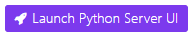

You are now ready to add your new application to Prometheus.

# Step 8: Reconfigure Prometheus

* Now that you have your application running, it is time to reconfigure Prometheus so that it knows about the new **`pythonserver`** node to monitor. 
* You can do this by adding the Python server as a target in your **`prometheus.yml`** file.

## Your Task

1. First, open the `prometheus.yml` file:

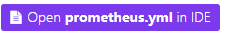


2. Next, create a new job to monitor the **`pythonserver`** service that is listening on port **`8080`**. Use the previous job as an example.

*Create a new job name and change the target in **`prometheus.yml`** to point to the **server url** of your **`pythonserver`** and port:*
```
  - job_name: {make up a job name here}
    static_configs:
      - targets: [{place the target to monitor here}]
        labels:
          group: {make up a group name here}
```

*You may have created a different **`job_name`** or **`group`** but the **`targets`** must match the target below:*
```
  - job_name: 'monitorPythonserver'
    static_configs:
      - targets: ['pythonserver:8080']
        labels:
          group: 'monitoring_python'
```

3. Check that your complete **`prometheus.yml`** file looks similar to this one:
```
# my global config
global:
  scrape_interval: 15s # Set the scrape interval to every 15 seconds. The default is every 1 minute.

scrape_configs:
  - job_name: 'monitorPythonserver'
    static_configs:
      - targets: ['pythonserver:8080']
        labels:
          group: 'monitoring_python'

  - job_name: 'node'
    static_configs:
      - targets: ['node-exporter1:9100']
        labels:
          group: 'monitoring_node_ex1'
      - targets: ['node-exporter2:9100']
        labels:
          group: 'monitoring_node_ex2'
      - targets: ['node-exporter3:9100']
        labels:
          group: 'monitoring_node_ex3'
```

4. Restart the prometheus server to pick up the new configuration changes:
```
docker restart prometheus
```

5. Check the Prometheus UI to see the new Targets.

> **Note**: You may have to click the **“show more”** button next to **`monitorPythonserver`** as depicted below:

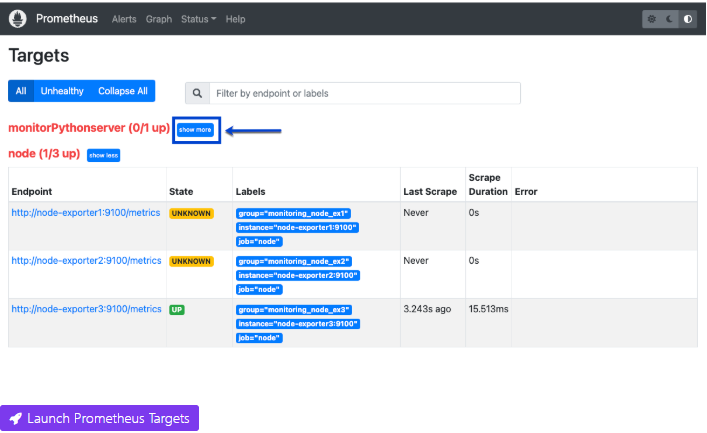



## Results

If everything went well, when you open the Prometheus targets, you will see the status of your Python server as in the image below.

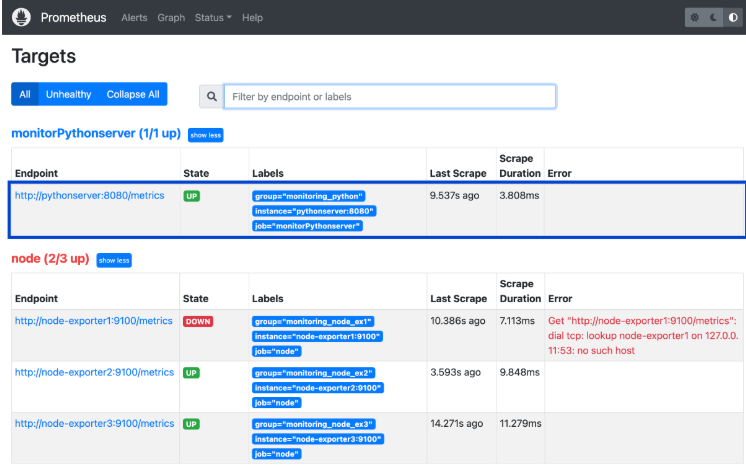

# Step 9: Monitor your application

In order to see some results of monitoring, you need to generate some network traffic.

1. Make multiple requests to the three endpoints of the Python server you created in the previous task and observe these calls on Prometheus.

```
curl localhost:8081
curl localhost:8081/home
curl localhost:8081/contact
```

> *Feel free to run these multiple times to simulate real network traffic*.

2. Use the Prometheus UI to query for the following metrics.

* `flask_http_request_duration_seconds_bucket`
* `flask_http_request_total`
* `process_virtual_memory_bytes`

If you are interested in what other metrics are being emitted by your application, you can view all of the metrics that your application is emitting by opening the **`/metrics`** endpoint just like Prometheus does. Feel free to experiment by running queries against other metrics:

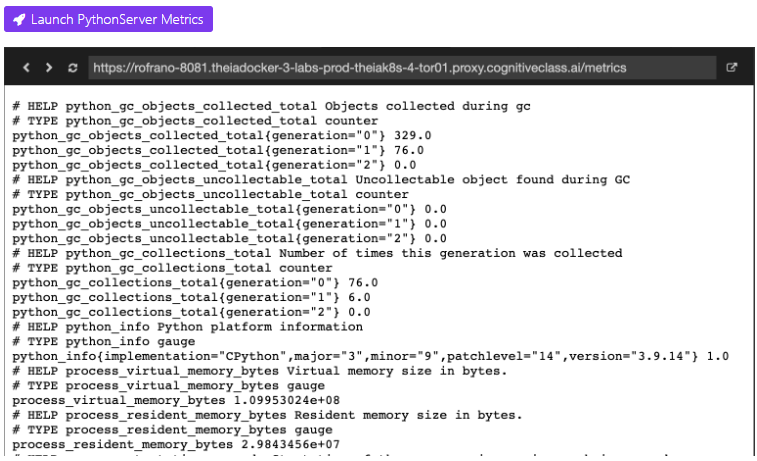

# Conclusion

**Congratulations!**
* You have completed the lab on **Monitoring with Prometheus**. 
* You are now well on your way to monitoring your own applications to ensure they are running properly.

In this lab, you deployed three node exporters and used Prometheus metrics to monitor them. 

You also learned how to instrument a Python Flask application, deploy it in Docker, and modify the Prometheus configuration to start monitoring this new application.

# Next Steps

* Your next challenge is to set up Prometheus in your development environment to monitor your applications.
* Use the **Prometheus Flask exporter** to instrument one of your Python Flask applications.
* Then use some of the queries you have learned in this lab to check on the health and performance of your application.